Use of Prophet libraries to forecast time series data

In [1]:
#Libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import time
from dateutil.easter import *
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import glob
import datetime
import os
import sys
import re
import gc
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.metrics import mean_squared_error
from math import nan
# %pip install folium==0.2.1
# %pip install pyjanitor -q
# %pip install snowflake-connector-python -q
warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Load the information
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())
#VENTAS_DATA is the path where the sales database is located.
sales = pd.read_parquet(os.environ['VENTAS_DATA'])
sales.head(3)

Python-dotenv could not parse statement starting at line 17
Python-dotenv could not parse statement starting at line 23
Python-dotenv could not parse statement starting at line 27


,fecha,Venta
0,2019-01-01,20393645.81
1,2019-01-02,11407249.53
2,2019-01-03,11006611.73


In [3]:
sales.describe()

,Venta
count,9.740000e+02
mean,1.530073e+07
std,4.792781e+06
min,8.782161e+06
25%,1.164526e+07
50%,1.344228e+07
75%,1.851197e+07
max,4.045416e+07


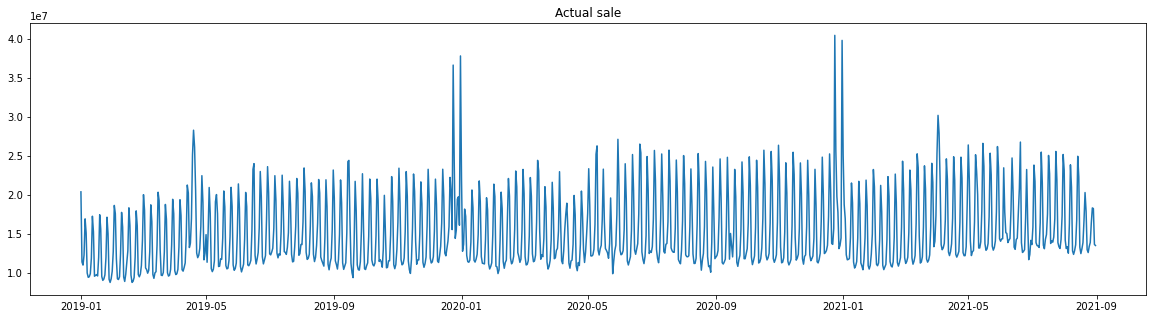

In [4]:
plt.figure(figsize = (20,5))
plt.plot(sales.fecha, sales.Venta)
plt.title('Actual sale')
plt.show()

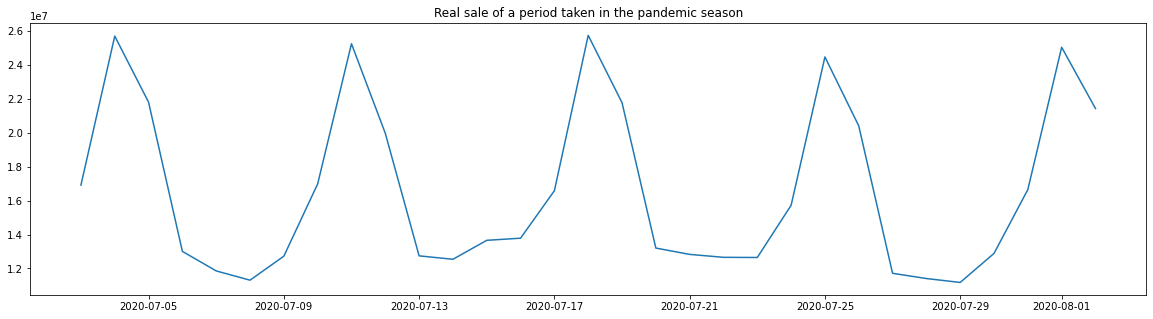

In [5]:
#To see the weekly behavior during pandemic
plt.figure(figsize = (20,5))
plt.plot(sales.fecha.iloc[549:580], sales.Venta.iloc[549:580])
plt.title('Real sale of a period taken in the pandemic season')
plt.show()

## Construction of a model with default params and without exogenous variables
### Format definition

In [7]:
#Format required by prophet libraries.
df = sales.rename(columns= {"fecha":"ds", "Venta":"y"})
#Training and testing set
size = int(len(df)*0.7)
train = df.iloc[:size]
test = df.iloc[size:]

In [8]:
print(train.tail())
print(test.head())

            ds             y
676 2020-11-07  2.411672e+07
677 2020-11-08  2.024575e+07
678 2020-11-09  1.149936e+07
679 2020-11-10  1.102706e+07
680 2020-11-11  1.131945e+07
            ds             y
681 2020-11-12  1.174101e+07
682 2020-11-13  1.604341e+07
683 2020-11-14  2.546953e+07
684 2020-11-15  2.261767e+07
685 2020-11-16  1.457476e+07


In [9]:
len(test) #9 months and a half

293

In [10]:
#Holiday database creation
fest = pd.read_excel(os.environ['FESTIVIDADES'], skiprows = 1, header = 1)
#IE and FE indicate the start and end date of the holiday, respectively
fest = fest[['Nombre', 'IE','FE']]
fest['IE'] = pd.to_datetime(fest['IE']).dt.floor('d')
fest['FE'] = pd.to_datetime(fest['FE']).dt.floor('d')
fest.drop_duplicates()

#Defining the format: date-holiday
clean = []
for x in list(range(0,len(fest))):
    name = fest['Nombre'].iloc[x]
    first_date = fest['IE'].iloc[x]
    second_date = fest['FE'].iloc[x]
    fechas = list(pd.date_range(start=first_date,end=second_date))
    df_festividades =pd.DataFrame({'date': fechas,
                          'name': name})
    clean.append(df_festividades)
holidays = pd.concat(clean,axis=0,ignore_index=True)
#Día del Dulces and Dia del Dulces have the same values, but the first one has an accent and the other doesn't.
indexNames = holidays[holidays['name'] == 'Día del Dulces' ].index
holidays.drop(indexNames , inplace=True)
#The information on holidays must be registered from where the historical data begins, up to the dates on which the forecast is to be made.
holidays = holidays[(holidays.date >= train.ds.min()) & (holidays.date <= test.ds.max())] 
holidays = pd.DataFrame(holidays.drop_duplicates())
holidays = holidays.rename(columns= {"date":"ds", "name":"holiday"})
holidays = holidays[['holiday', 'ds']]
holidays

,holiday,ds
1792,Temporada Extranjeros,2019-01-01
1793,Temporada Extranjeros,2019-01-02
1794,Temporada Extranjeros,2019-01-03
1795,Temporada Extranjeros,2019-01-04
1796,Temporada Extranjeros,2019-01-05
...,...,...
4535,Torneo Internacional de Pesca Martín y Tuna 2021,2021-08-26
4536,Fiestas Usmajac,2021-08-28
4537,Fiestas Usmajac,2021-08-29
4538,Fiestas Usmajac,2021-08-30


### Model definition

In [11]:
#Seasonality is defined daily due to the structure of the series, also the confidence level for the interval is defined
m = Prophet(holidays = holidays, daily_seasonality=True, interval_width = 0.8)
m.fit(train)
future = m.make_future_dataframe(periods = len(test), freq = 'D')
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


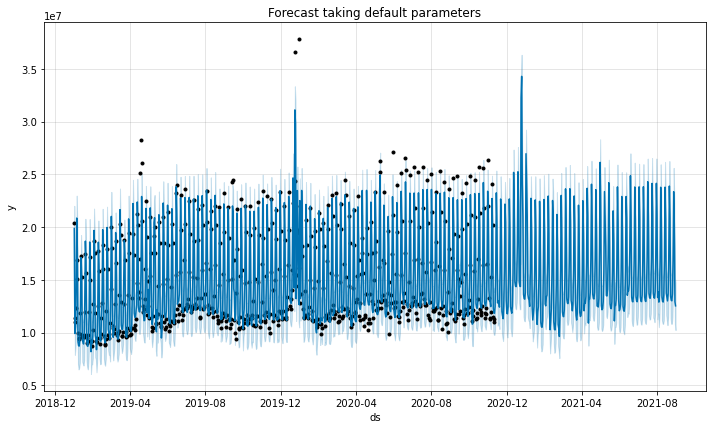

In [12]:
m.plot(forecast)
plt.title('Forecast taking default parameters')
plt.show()

Decomposition of sales taking default parameters for adjustment


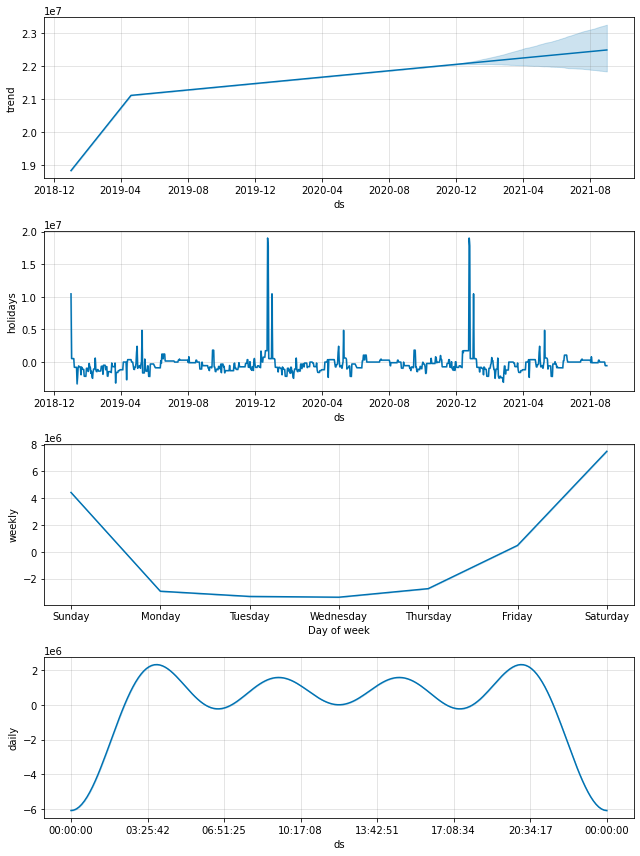

In [13]:
print('Decomposition of sales taking default parameters for adjustment')
m.plot_components(forecast)
plt.show()

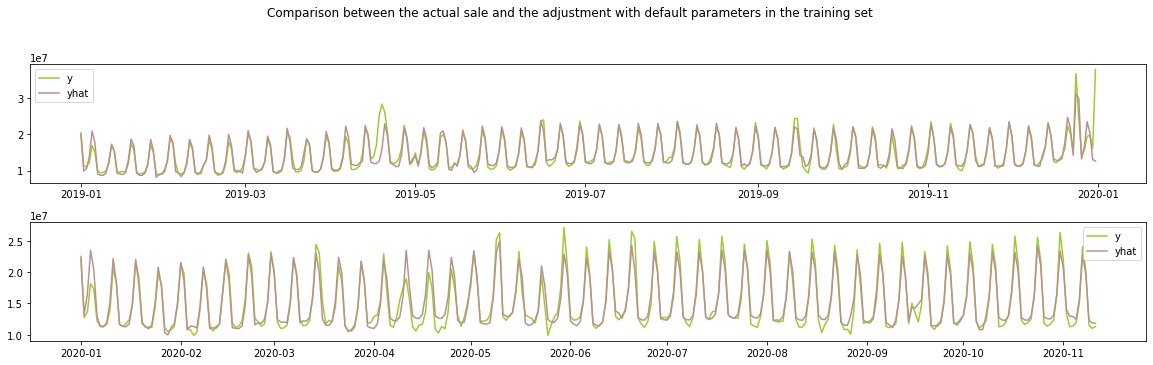

In [20]:
#Annual fitting
fig = plt.figure(figsize=(20,8))
plt.suptitle('Comparison between the actual sale and the adjustment with default parameters in the training set')
ax1 = plt.subplot2grid((6,1),(0,0), rowspan=2, colspan=1)
ax2 = plt.subplot2grid((6,1),(2,0), rowspan=2, colspan=1)
ax1.plot(train.ds.head(365),train.y.head(365), label = 'y', color = 'yellowgreen')
ax1.plot(forecast.ds.head(365), forecast.yhat.head(365), label = 'yhat', color = 'rosybrown')
plt.subplots_adjust(hspace=1)
ax1.legend()

ax2.plot(train.ds.iloc[365:len(train)],train.y.iloc[365:len(train)], label = 'y', color = 'yellowgreen')
ax2.plot(forecast.ds.iloc[365:len(train)],forecast.yhat.iloc[365:len(train)], label = 'yhat', color = 'rosybrown')
ax2.legend()
plt.show()

### Predictions

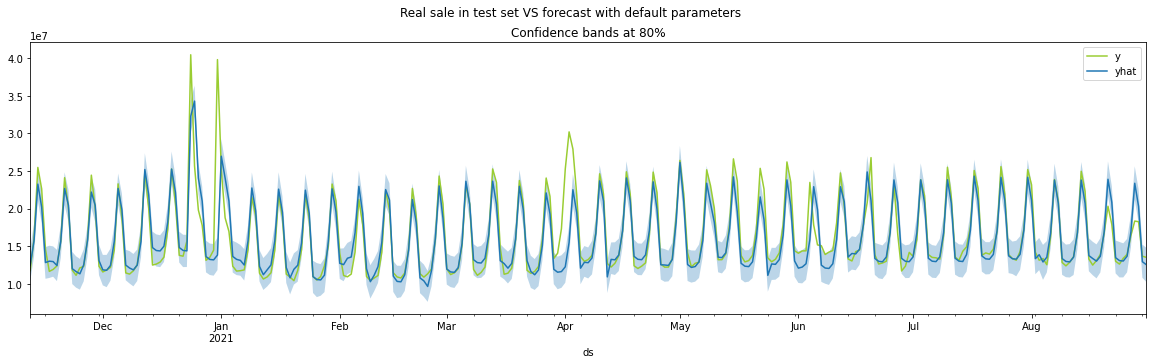

In [21]:
test_b = test.copy()
test_b.set_index('ds', inplace = True)
test_b.plot(figsize = (20,5),label = 'Actual sales in testing set', color = 'yellowgreen')
forecast_b = forecast.copy()
forecast_b.set_index('ds', inplace = True)
forecast_b.yhat.tail(len(test_b)).plot(label = 'yhat')
x = pd.date_range(start=test.ds.min(), end=test.ds.max()+datetime.timedelta(1), freq='d')[:-1]
plt.fill_between(x, forecast.yhat_lower.tail(len(test)), forecast.yhat_upper.tail(len(test)), alpha=0.3)
plt.suptitle('Real sale in test set VS forecast with default parameters')
plt.title('Confidence bands at 80%')
plt.legend()
plt.show()

### Evaluate the model

In [249]:
def evaluate_model(real_y, fitted_y):
    '''
    The evaluate_model() function will calculate the RMSE score for each day
    :param real_y: actual time series values
    :type real_y: np.array
    :param fitted_y: fitted values for the time series
    :type fitted_y: np.array
    :return: the rmse scores for each observation and the rmse of the total data
    '''
    scores = [] #The array where de RMSE scores will be hosted

    #Calculate scores for each day
    for i in range(len(real_y)):
        rmse = np.sqrt(mean_squared_error([real_y[i]],[fitted_y[i]]))
        scores.append(rmse)

    #Calculate score for whole prediction
    total_score = np.sqrt(mean_squared_error(real_y,fitted_y))
    return scores, total_score

In [23]:
day_rmse_train, total_rmse_train = evaluate_model(np.array(forecast.yhat.head(len(train))),np.array(train.y))
day_rmse_test, total_rmse_test = evaluate_model(np.array(forecast.yhat.tail(len(test))), np.array(test.y))

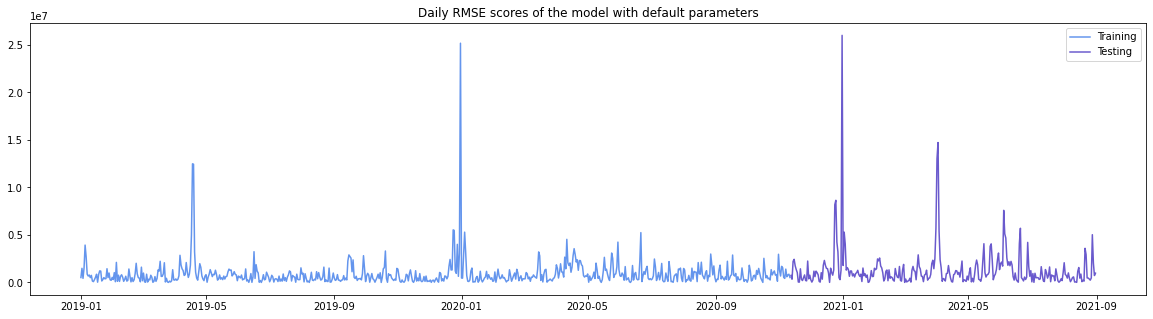

In [24]:
plt.figure(figsize = (20,5))
plt.plot(train.ds,day_rmse_train, label = 'Training', color = 'cornflowerblue')
plt.plot(test.ds,day_rmse_test, label = 'Testing', color = 'slateblue')
plt.title('Daily RMSE scores of the model with default parameters')
plt.legend()
plt.show()

In [25]:
print(f'RMSE of the training data: {total_rmse_train}')
print(f'RMSE of the testing data: {total_rmse_test}')

RMSE of the training data: 1645738.514798392
RMSE of the testing data: 2577277.8851985


In [27]:
print(f'Mean of the training data: {np.mean(train.y)}')
print(f'Sd of the training data: {np.std(train.y)}')
print(f'Mean of the testing data: {np.mean(test.y)}')
print(f'Sd of the testing data: {np.std(test.y)}')

Mean of the training data: 14857775.606361968
Sd of the training data: 4596470.5635410445
Mean of the testing data: 16330251.830914002
Sd of the testing data: 5065612.770000913


##  Model with conditional seasonality and regressors

* Conditional seasonality helps to model a different seasonal pattern depending on the season of the year. Those dates outside the pandemic where sales are normal will be taken as 'in season', and 'out of season' when the epidemiological semaphore does not allow normal behavior of the economy.

* Regressors add extra weight to certain days. Two variables will be created:
    * xmas: to model december 24,25 and 31st; and January 1st
    * holyw: to model from thursday to sunday on holyweek

In [250]:
dfc = df.copy()
#Conditional seasonality
def is_off_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3 and date.year == 2020) or (date.year == 2021))
#https://izai.org.mx/covid19/2021/12/13/semaforo-epidemiologico-covid-19/

dfc['on_season'] = ~dfc['ds'].apply(is_off_season)
dfc['off_season'] =dfc['ds'].apply(is_off_season)
dfc

,ds,y,on_season,off_season
0,2019-01-01,2.039365e+07,True,False
1,2019-01-02,1.140725e+07,True,False
2,2019-01-03,1.100661e+07,True,False
3,2019-01-04,1.229563e+07,True,False
4,2019-01-05,1.693130e+07,True,False
...,...,...,...,...
969,2021-08-27,1.640942e+07,False,True
970,2021-08-28,1.833815e+07,False,True
971,2021-08-29,1.824773e+07,False,True
972,2021-08-30,1.365771e+07,False,True


In [251]:
#The easter() function returns the date of the second Sunday of Easter, passing the year you want to consult
h_19 = list(pd.date_range(easter(2019) - datetime.timedelta(3), easter(2019)))
h_21 = list(pd.date_range(easter(2021) - datetime.timedelta(3), easter(2021)))
holyweek = pd.to_datetime(h_19 + h_21)
holyweek

DatetimeIndex(['2019-04-18', '2019-04-19', '2019-04-20', '2019-04-21',
               '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04'],
              dtype='datetime64[ns]', freq=None)

In [252]:
#Regressors
def holyw(ds):
    date = pd.to_datetime(ds)
    if (date.strftime('%Y-%m-%d') in holyweek):
        return 1
    else:
        return 0
def xmas(ds):
    date = pd.to_datetime(ds)
    if ((date.day in (24,25,31)) and date.month== 12) or (date.month ==1 and date.day == 1):
        return 1
    else:
        return 0
dfc['xmas'] = dfc['ds'].apply(xmas)
dfc['holyw'] = dfc['ds'].apply(holyw)

In [253]:
dfc[dfc.xmas == 1]

,ds,y,on_season,off_season,xmas,holyw
0,2019-01-01,2.039365e+07,True,False,1,0
357,2019-12-24,3.664367e+07,True,False,1,0
358,2019-12-25,2.437078e+07,True,False,1,0
364,2019-12-31,3.781694e+07,True,False,1,0
365,2020-01-01,2.204666e+07,True,False,1,0
723,2020-12-24,4.045416e+07,False,True,1,0
724,2020-12-25,2.564985e+07,False,True,1,0
730,2020-12-31,3.980828e+07,False,True,1,0
731,2021-01-01,2.517476e+07,False,True,1,0


In [254]:
dfc[dfc.holyw == 1]

,ds,y,on_season,off_season,xmas,holyw
107,2019-04-18,25104655.48,True,False,0,1
108,2019-04-19,28297366.78,True,False,0,1
109,2019-04-20,26111870.76,True,False,0,1
110,2019-04-21,20536634.88,True,False,0,1
821,2021-04-01,25256373.18,False,True,0,1
822,2021-04-02,30197891.46,False,True,0,1
823,2021-04-03,27911574.71,False,True,0,1
824,2021-04-04,21811262.16,False,True,0,1


In [255]:
#Training and testing set
size = int(len(dfc)*0.7)
trainc = dfc.iloc[:size]
testc = dfc.iloc[size:]

In [256]:
trainc.tail(3)

,ds,y,on_season,off_season,xmas,holyw
678,2020-11-09,1.149936e+07,False,True,0,0
679,2020-11-10,1.102706e+07,False,True,0,0
680,2020-11-11,1.131945e+07,False,True,0,0


### Model definition

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


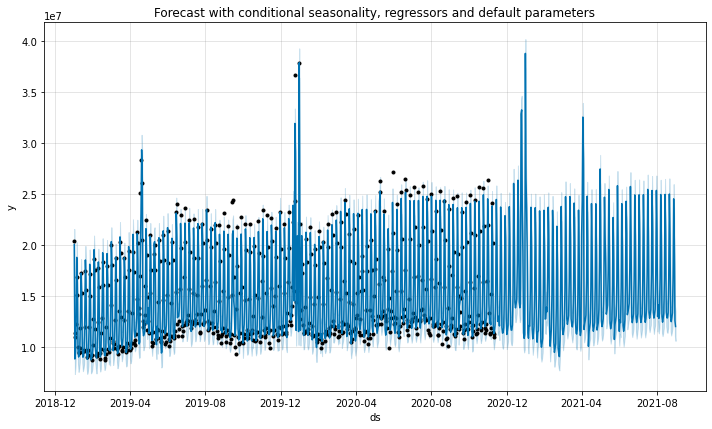

In [257]:
mc = Prophet(holidays = holidays, daily_seasonality=True, interval_width = 0.8, weekly_seasonality = False)
mc.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
mc.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')
Prophet.add_regressor(mc,'xmas')
Prophet.add_regressor(mc,'holyw')
mc.fit(trainc)

futurec = mc.make_future_dataframe(periods = len(testc), freq = 'D')
futurec['on_season'] = ~futurec['ds'].apply(is_off_season)
futurec['off_season'] = futurec['ds'].apply(is_off_season)
futurec['xmas'] = futurec['ds'].apply(xmas)
futurec['holyw'] = futurec['ds'].apply(holyw)
forecastc = mc.predict(futurec)
mc.plot(forecastc)
plt.title('Forecast with conditional seasonality, regressors and default parameters')
plt.show()

Decomposition of sales taking default parameters for adjustment, conditional seasonality and regressors


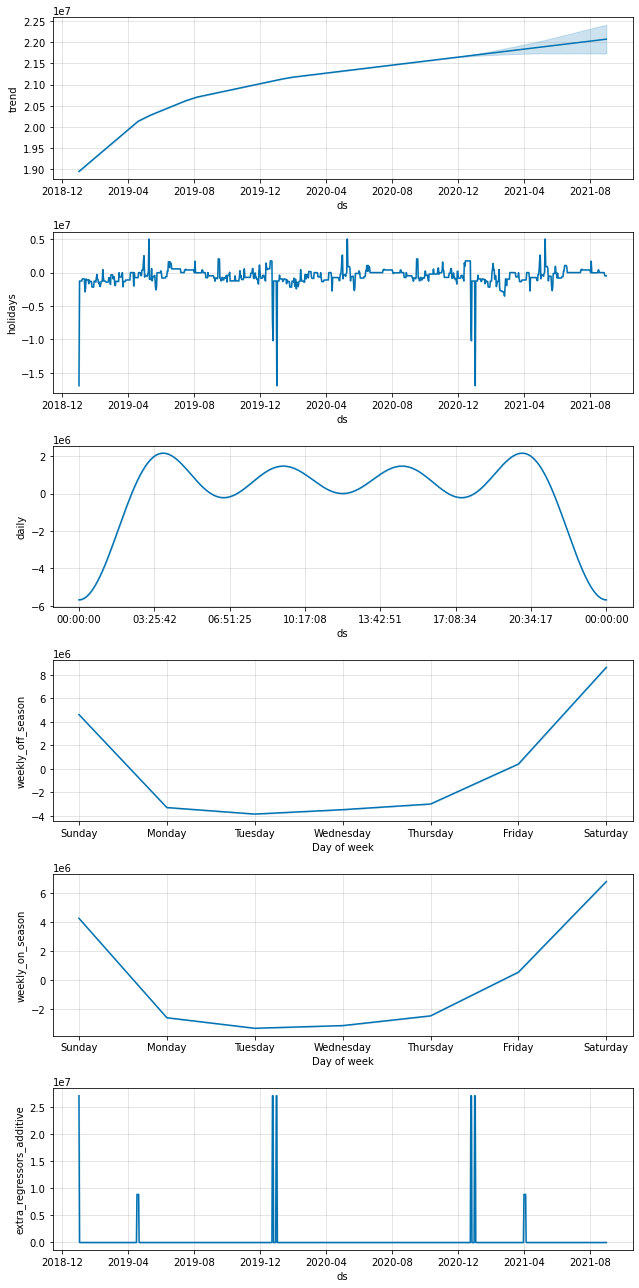

In [258]:
print('Decomposition of sales taking default parameters for adjustment, conditional seasonality and regressors')
mc.plot_components(forecastc)
plt.show()

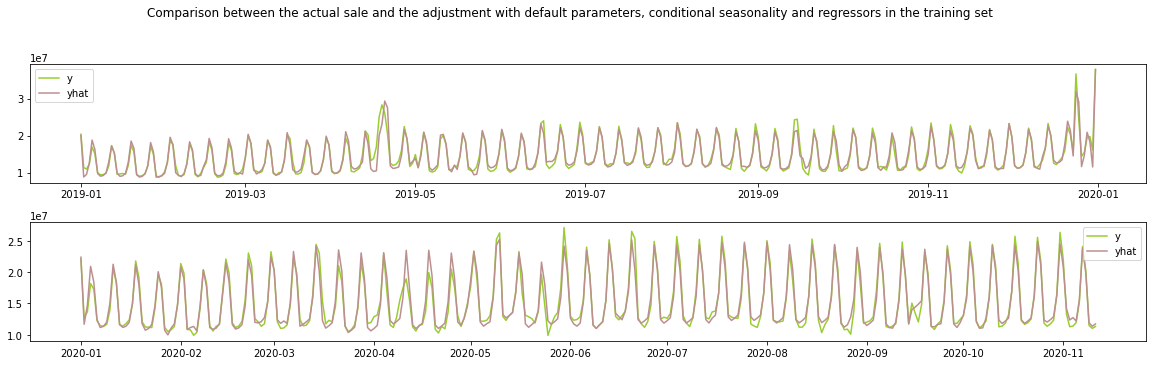

In [259]:
#Annual fitting comparition
fig = plt.figure(figsize=(20,8))
plt.suptitle('Comparison between the actual sale and the adjustment with default parameters, conditional seasonality and regressors in the training set')
ax1 = plt.subplot2grid((6,1),(0,0), rowspan=2, colspan=1)
ax2 = plt.subplot2grid((6,1),(2,0), rowspan=2, colspan=1)

ax1.plot(trainc.ds.head(365), trainc.y.head(365), label = 'y', color = 'yellowgreen')
ax1.plot(forecastc.ds.head(365), forecastc.yhat.head(365), label = 'yhat', color = 'rosybrown')
plt.subplots_adjust(hspace=1)
ax1.legend()

ax2.plot(trainc.ds.iloc[365:len(trainc)], trainc.y.iloc[365:len(trainc)], label = 'y', color = 'yellowgreen')
ax2.plot(forecastc.ds.iloc[365:len(trainc)], forecastc.yhat.iloc[365:len(trainc)], label = 'yhat', color = 'rosybrown')
ax2.legend()
plt.show()

### Predictions

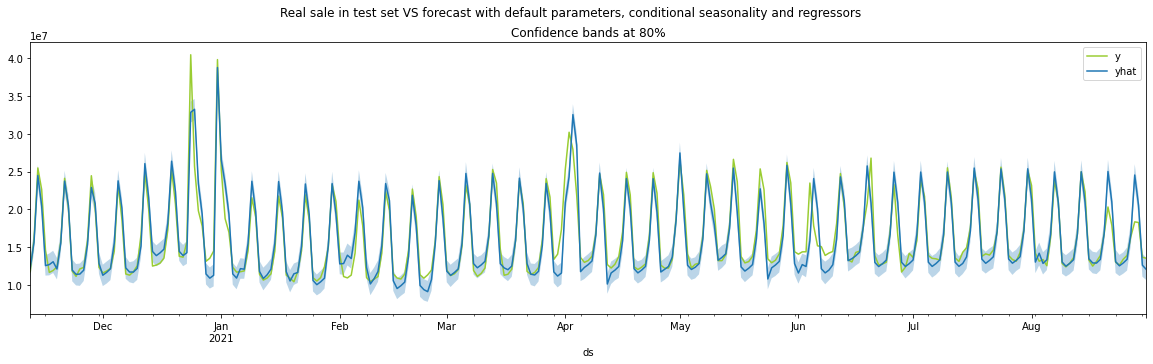

In [261]:
test_bc = testc.copy()
test_bc.set_index('ds', inplace = True)
test_bc.y.plot(figsize = (20,5),label = 'y', color = 'yellowgreen')
forecast_bc = forecastc.copy()
forecast_bc.set_index('ds', inplace = True)
forecast_bc.yhat.tail(len(test_bc)).plot(label = 'yhat')
x = pd.date_range(start=test.ds.min(), end=test.ds.max()+datetime.timedelta(1), freq='d')[:-1]
plt.fill_between(x, forecastc.yhat_lower.tail(len(testc)), forecastc.yhat_upper.tail(len(testc)), alpha=0.3)
plt.suptitle('Real sale in test set VS forecast with default parameters, conditional seasonality and regressors')
plt.title('Confidence bands at 80%')
plt.legend()
plt.show()

### Evaluate the model

In [262]:
day_rmse_train_cs_r, total_rmse_train_cs_r = evaluate_model(np.array(forecast_bc.yhat.head(len(trainc))),np.array(trainc.y))
day_rmse_test_cs_r, total_rmse_test_cs_r = evaluate_model(np.array(forecast_bc.yhat.tail(len(test_bc))), np.array(test_bc.y))

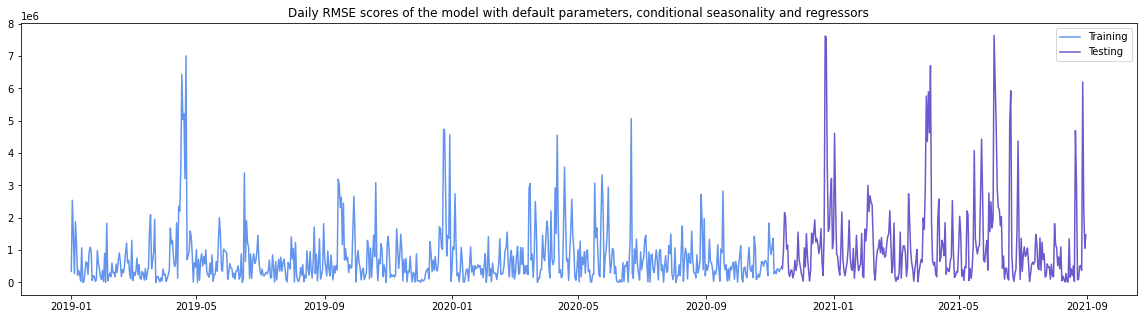

In [263]:
plt.figure(figsize = (20,5))
plt.plot(trainc.ds,day_rmse_train_cs_r, label = 'Training', color = 'cornflowerblue')
plt.plot(test_bc.index,day_rmse_test_cs_r, label = 'Testing', color = 'slateblue')
plt.title('Daily RMSE scores of the model with default parameters, conditional seasonality and regressors')
plt.legend()
plt.show()

In [264]:
print(f'RMSE of the training data: {total_rmse_train_cs_r}')
print(f'RMSE of the testing data: {total_rmse_test_cs_r}')

RMSE of the training data: 1105250.8061157796
RMSE of the testing data: 1830633.6911697104


In [265]:
print(f'Mean of the training data: {np.mean(train.y)}')
print(f'Sd of the training data: {np.std(train.y)}')
print(f'Mean of the testing data: {np.mean(test.y)}')
print(f'Sd of the testing data: {np.std(test.y)}')

Mean of the training data: 14857775.606361968
Sd of the training data: 4596470.5635410445
Mean of the testing data: 16330251.830914002
Sd of the testing data: 5065612.770000913


## Model using cross-validation to find the best params; conditional seasonality and regressors

In [267]:
param_grid = {
    'changepoint_prior_scale': [0.001,0.01,0.1, 0.5],
    'seasonality_prior_scale': [0.01,1,10.0],
    'holidays_prior_scale': [15,10, 0.01]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [268]:
for i in all_params:
    i['holidays'] = holidays
    i['daily_seasonality'] = True

In [271]:
rmses = []  #List that will store the errors

#Cross validation to evaluate the parameters
for params in all_params:
    m = Prophet(**params).fit(trainc)  # Fitting the model with the given parameters
    df_cv = cross_validation(m, initial = '500 days', period ='30 days' , horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

#Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2020-05-15 00:00:00 and 2020-08-13 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D4EAC4DB50>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2020-05-15 00:00:00 and 2020-08-13 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D4E7EBF340>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2020-05-15 00:00:00 and 2020-08-13 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D4E6008640>
INFO:fbprophet:Disabling yearly se

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     0.01                 15.00   
1                     0.001                     0.01                 10.00   
2                     0.001                     0.01                  0.01   
3                     0.001                     1.00                 15.00   
4                     0.001                     1.00                 10.00   
5                     0.001                     1.00                  0.01   
6                     0.001                    10.00                 15.00   
7                     0.001                    10.00                 10.00   
8                     0.001                    10.00                  0.01   
9                     0.010                     0.01                 15.00   
10                    0.010                     0.01                 10.00   
11                    0.010                     0.01            

### Fitting the model with parameters given by the cv

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


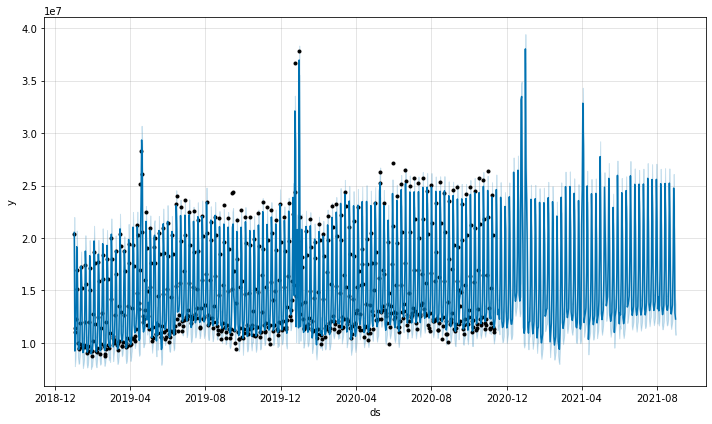

In [273]:
#The parameters that give the lowest value for the RMSE score are: changepoint_prior_scale = 0.05, seasonality_prior_scale = 0.01, holidays_prior_scale = 15
mvc = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 1, holidays_prior_scale = 15, holidays = holidays, daily_seasonality = True, interval_width = 0.8)
mvc.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
mvc.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')
Prophet.add_regressor(mvc,'xmas')
Prophet.add_regressor(mvc,'holyw')
mvc.fit(trainc)

futurevc = mvc.make_future_dataframe(periods = len(testc), freq = 'D')
futurevc['on_season'] = ~futurevc['ds'].apply(is_off_season)
futurevc['off_season'] = futurevc['ds'].apply(is_off_season)
futurevc['xmas'] = futurevc['ds'].apply(xmas)
futurevc['holyw'] = futurevc['ds'].apply(holyw)
forecastvc = mvc.predict(futurevc)
mvc.plot(forecastvc)
plt.show()

Decomposition of sales with conditional seasonality, regressors; and taking the parameters given by cv


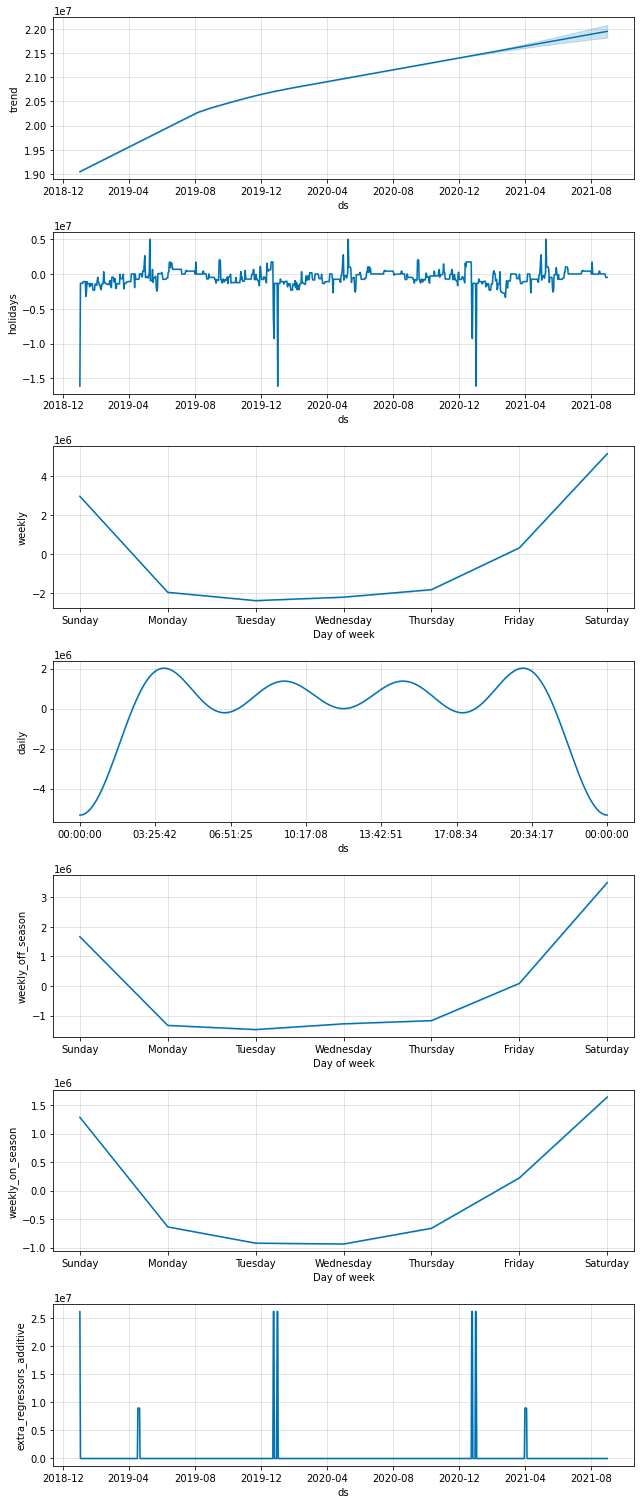

In [274]:
print('Decomposition of sales with conditional seasonality, regressors; and taking the parameters given by cv')
mvc.plot_components(forecastvc)
plt.show()

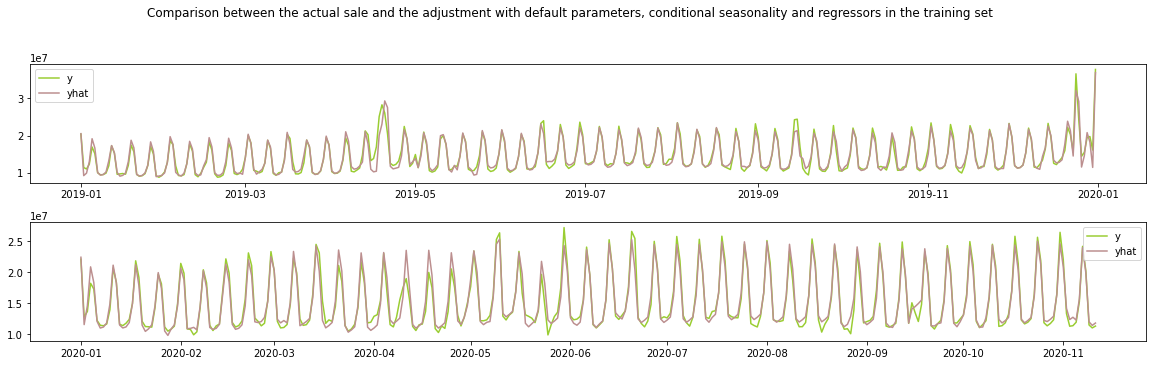

In [276]:
#Annual fitting comparison
fig = plt.figure(figsize=(20,8))
plt.suptitle('Comparison between the actual sale and the adjustment with parameters given by cv, conditional seasonality and regressors in the training set')
ax1 = plt.subplot2grid((6,1),(0,0), rowspan=2, colspan=1)
ax2 = plt.subplot2grid((6,1),(2,0), rowspan=2, colspan=1)

ax1.plot(trainc.ds.head(365), trainc.y.head(365), label = 'y', color = 'yellowgreen')
ax1.plot(forecastvc.ds.head(365), forecastvc.yhat.head(365), label = 'yhat', color = 'rosybrown')
plt.subplots_adjust(hspace=1)
ax1.legend()

ax2.plot(trainc.ds.iloc[365:len(trainc)], trainc.y.iloc[365:len(trainc)], label = 'y', color = 'yellowgreen')
ax2.plot(forecastvc.ds.iloc[365:len(trainc)], forecastvc.yhat.iloc[365:len(trainc)], label = 'yhat', color = 'rosybrown')
ax2.legend()
plt.show()

### Predictions

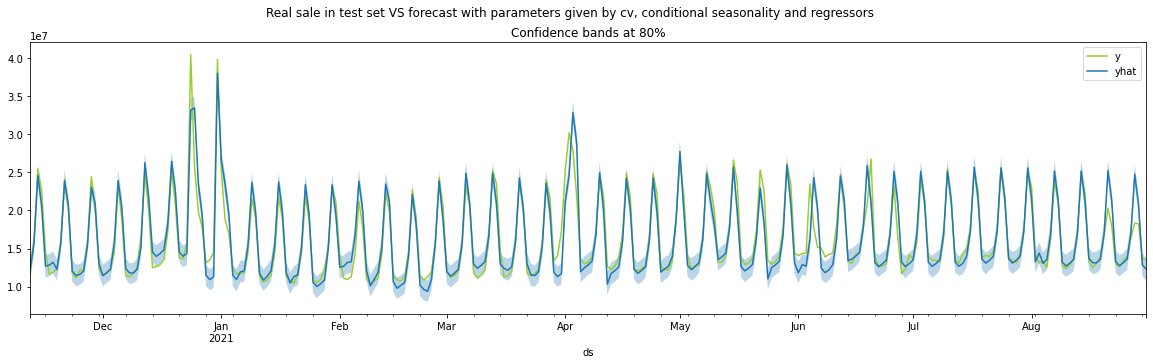

In [277]:
test_bc = testc.copy()
test_bc.set_index('ds', inplace = True)
test_bc.y.plot(figsize = (20,5),label = 'y', color = 'yellowgreen')
forecast_vbc = forecastvc.copy()
forecast_vbc.set_index('ds', inplace = True)
forecast_vbc.yhat.tail(len(test_bc)).plot(label = 'yhat')
x = pd.date_range(start=test.ds.min(), end=test.ds.max()+datetime.timedelta(1), freq='d')[:-1]
plt.fill_between(x, forecastvc.yhat_lower.tail(len(testc)), forecastvc.yhat_upper.tail(len(testc)), alpha=0.3)
plt.suptitle('Real sale in test set VS forecast with parameters given by cv, conditional seasonality and regressors')
plt.title('Confidence bands at 80%')
plt.legend()
plt.show()

### Evaluate the model

In [278]:
day_rmse_train_cs_r_cv, total_rmse_train_cs_r_cv = evaluate_model(np.array(forecastvc.yhat.head(len(trainc))),np.array(trainc.y))
day_rmse_test_cs_r_cv, total_rmse_test_cs_r_cv = evaluate_model(np.array(forecastvc.yhat.tail(len(testc))), np.array(testc.y))

In [280]:
print(f'RMSE of the training data: {total_rmse_train_cs_r_cv}')
print(f'RMSE of the testing data: {total_rmse_test_cs_r_cv}')

RMSE of the training data: 1113414.8959214624
RMSE of the testing data: 1799208.5413472692


In [281]:
print(f'Mean of the test set: {np.mean(test.y)}')
print(f'Sd of the test set: {np.std(test.y)}')

Mean of the test set: 16330251.830914002
Sd of the test set: 5065612.770000913


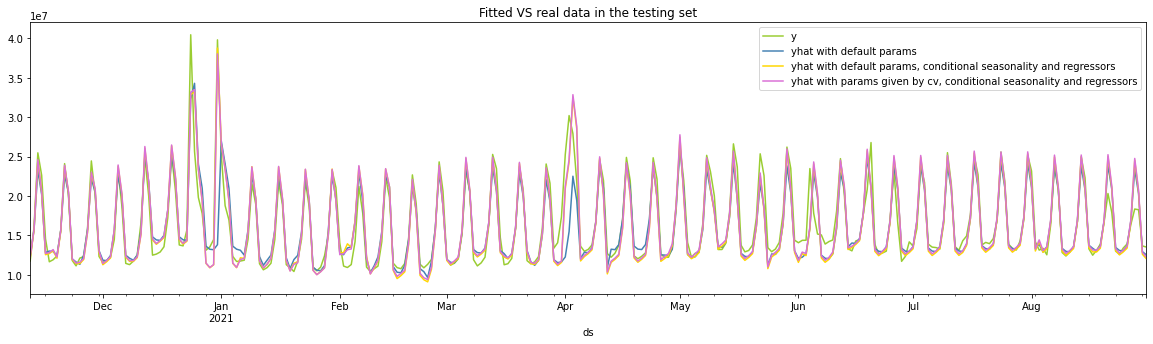

In [282]:
test_bc.y.plot(figsize = (20,5),label = 'y', color = 'yellowgreen')
forecast_b.yhat.tail(len(test_b)).plot(label = 'yhat with default params', color = 'steelblue')
forecast_bc.yhat.tail(len(test_bc)).plot(label = 'yhat with default params, conditional seasonality and regressors', color = 'gold')
forecast_vbc.yhat.tail(len(test_bc)).plot(label = 'yhat with params given by cv, conditional seasonality and regressors', color = 'orchid')
plt.title('Fitted VS real data in the testing set')
plt.legend()
plt.show()

In [283]:
#Save the model to use when comparing it to other methodologies
#The best model is the one with conditional seasonality, regressors and the params given by cross-validation
path = os.environ['PROCESSED_PATH']
os.chdir(path)
# forecastvc.to_parquet(f'{path}prophet_data.parquet')
import json
from prophet.serialize import model_to_json, model_from_json
with open('prophet_model.json', 'w') as fout:
    json.dump(model_to_json(mvc), fout)  # Save model